# Оценяване и валидиране на модели

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mglearn
import warnings

warnings.filterwarnings(action='ignore', module='scipy', message='^internal gelsd')

%matplotlib inline

In [2]:
# ignore sklearn's convergence warning 
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

## Целите днес: 

1. Оценяване на модел
2. Увереност на модел
3. Крос-валидация

# Оценяване на модел

Когато искаме да определим колко добре се справя даден модел може да ползваме различни методи за оценяването му. Няма универсална формула – всичко зависи от конкретните данни и целта ни с тях.

Ще разгледаме няколко различни подхода.

Подходите за оценка на регресия и класификация са различни.

Ще започнем с регресията и ще минем към класификацията.

# 1 част - Регресия

## Означения

Ще ползваме следните означения (примери в контекста на определяне на цени на апартаменти).

* $n$ – брой данни (колко апартамента имаме)
* $y \in \mathbb{R}^n$ – целеви стойности / target values (истинската цена на апартамент)
* $\hat{y} \in \mathbb{R}^n$ – предвидени стойности / predicted values (цени, предвидени от нашия модел)
* $\hat{y}_i \in \mathbb{R}$ – предвидена стойност на $i$-тия елемент (цена на $i$-тия апартамент според модела)

## Средна квадратична грешка

Още Mean Squared Error (MSE). Това е средно аритметичното на грешките в предвижданията:

$$
\operatorname {MSE} = \frac{1}{n} \sum_{i=1}^{n} \big( \hat{y}_i - y_i \big) ^ 2
$$

Обърнете внимание, че $\hat{y}_i - y_i$ е грешката за $i$-тия елемент (разликата между търсената стойност и какво казва моделът).

Когато ползваме линейна регресия (без регуларизация), алгоритъмът намира коефициенти $a_0, a_1, \ldots, a_n$, които минимизират тази функция.

Нека да видим пример. Първо, малко данни:

In [3]:
frame = pd.DataFrame({
    'y': [1, 3, 5, 10, 24, 55, 77],
    'ŷ': [1, 2, 5, 10, 30, 50, 100],
})

frame['correct'] = frame['y'] == frame['ŷ']
frame['difference'] = frame['ŷ'] - frame['y']
frame['squared_error'] = frame.difference**2

In [4]:
frame

,y,ŷ,correct,difference,squared_error
0,1,1,True,0,0
1,3,2,False,-1,1
2,5,5,True,0,0
3,10,10,True,0,0
4,24,30,False,6,36
5,55,50,False,-5,25
6,77,100,False,23,529


In [5]:
frame.squared_error.mean()

np.float64(84.42857142857143)

## RMSE

Корен квадратът от средната квадратична грешка се нарича RMSE (root mean square error). Използва се често като метрика за регресия, тъй като дава оценка в оригиналните мерни единици на данните (например долари).

$$
\operatorname {RMSE} = \sqrt{MSE} =  \sqrt{\frac{1}{n} \sum_{i=1}^{n} \big( \hat{y}_i - y_i \big) ^ 2}
$$

Въпрос:

Кой е най-добрият константен предиктор $c$ за горния сет $y$?

"Константен предиктор" ще рече $c = \hat{y}_1 = \hat{y}_2 = \ldots = \hat{y}_n$.

Нека пробваме да го намерим по "инженерен метод" (без математика). Просто ще пробваме числата между -100 и 100.

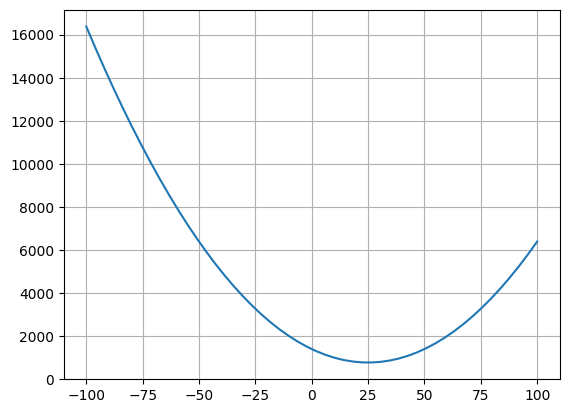

In [6]:
xs = np.linspace(-100, 100)
ys = [((frame.y - constant) ** 2).mean() for constant in xs]
plt.plot(xs, ys)
plt.grid();

Тази функция изглежда изпъкнала с минимум в `constant = 25`.

Интересно, но това е и средното-аритметично на $y$:

In [7]:
frame.y.mean()

np.float64(25.0)

Нека да наречем това Constant Model Mean Square Error (CMMSE). Т.е.:

$$
\operatorname{CMMSE} = \frac{1}{n} \sum_{i=1}^{n} \big( \bar{y} - y_i \big)^2
$$

Където $\bar{y}$ е средното-аритметично, т.е.:

$$
\bar{y} = \frac{1}{n} \sum_{i=1}^{n} y_i
$$

## $R^2$ – коефициент на детерминация

Най-популярната оценка при регресия е $R^2$. Тя се измерва с:

$$
\operatorname{R^2} = 1 - \frac{\operatorname{MSE}}{\operatorname{CMMSE}}
$$

Или по-подробно:

$$
\operatorname{R^2} =
 1 - \frac{\frac{1}{n} \sum_{i=1}^n \big( \hat{y}_i - y_i \big)^2}{\frac{1}{n} \sum_{i=1}^n \big( \bar{y} - y_i \big)^2}
$$

Обърнете внимание, че:

* Когато $\operatorname{MSE}$ е 0 имаме $R^2 = 1$ (максимална оценка)
* Когато $\operatorname{MSE}$ съвпада с този на константния модел имаме $R^2 = 0$
* $R^2$ може да е отрицателен (например при по-лош модел от оптималния константен модел)
* Оптимизиране на $\operatorname{MSE}$ оптимизира и $R^2$ (знаменателя е константен)

Накратко, baseline-а на $R^2$ е средното аритметично и оценява на нула. Всичко по-добре е положително число, като максималния резултат е 1. Всичко по-лошо е отрицателно число.

`score` на линейната регресия връща $R^2$ score. Това най-полезния метод за оценка за регресия в повечето практически ситуации.

Да илюстрираме това с малък есперимент. Ще вземем следните данни:

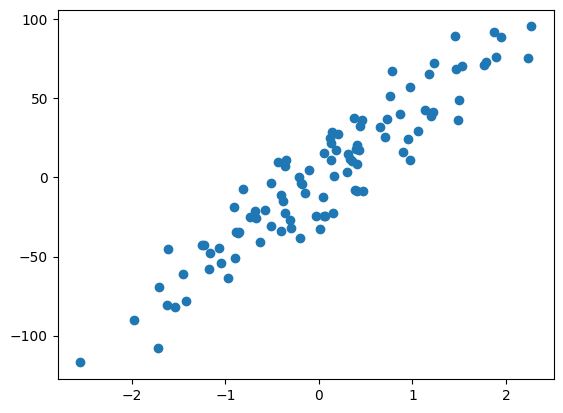

In [8]:
from sklearn.datasets import make_regression

X, y = make_regression(n_features=1, n_samples=100, noise=15.0, random_state=0)

plt.scatter(X, y);

Да натренираме линейна регресия:

In [9]:
from sklearn.linear_model import LinearRegression

model = LinearRegression().fit(X, y)
model.score(X, y)

0.8783794357491513

Видяхме какво връща `score`. Нека пробваме горната формула:

In [10]:
1 - ((model.predict(X) - y) ** 2).mean() / ((y.mean() - y) ** 2).mean()

np.float64(0.8783794357491513)

Получаваме същия резултат.

Може да видим и отрицателна стойност с много грешен модел (например винаги отговор 100):

In [11]:
from sklearn.dummy import DummyRegressor

model = DummyRegressor(strategy='constant', constant=100).fit(X, y)
model.score(X, y)

-4.608882849377867

При оптималния константен модел имаме $R^2 = 0$:

In [12]:
model = DummyRegressor(strategy='constant', constant=y.mean()).fit(X, y)
model.score(X, y)

0.0

## Mean Absolute Error (MAE)
    
$$
\operatorname{MAE} = \frac{1}{N} \sum_{i=1}^N \big| \hat y_i - y_i \big|
$$

* Използва се често във финансите
* €10 грешка е 2 пъти повече от €5 грешка
* При MSE €10 грешка е 4 по-лошо от €5 грешка
* По-устойчив на outliers

Забележете, че константия модел, оптимизиращ MSE не е същия като този, който оптимизира MAE.

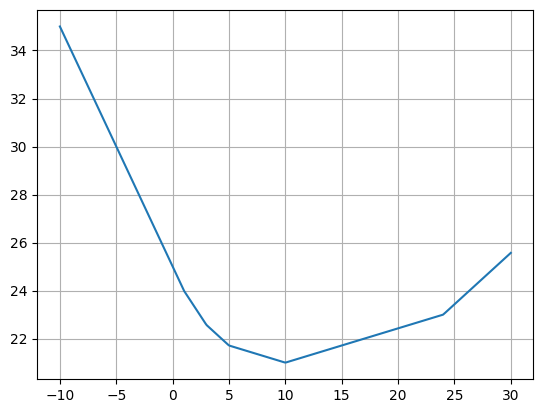

In [16]:
xs = np.linspace(-10, 30, 400)
ys = [(constant - frame.y).abs().mean() for constant in xs]
plt.plot(xs, ys)
plt.grid();

scikit-learn ви дава функции за тези метрики:

In [17]:
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

X, y = make_regression(n_features=1, n_samples=100, noise=15.0, random_state=0)
model = LinearRegression().fit(X, y)
y_pred = model.predict(X)

print("mean square error:   {}".format(mean_squared_error(y, y_pred)))
print("mean absolute error: {}".format(mean_absolute_error(y, y_pred)))
print("R² score:            {}".format(r2_score(y, y_pred)))

mean square error:   256.8858438784384
mean absolute error: 13.161296203224675
R² score:            0.8783794357491513


In [18]:
from sklearn.metrics import mean_squared_log_error

## Задача: 
    
По дадената таблица: 

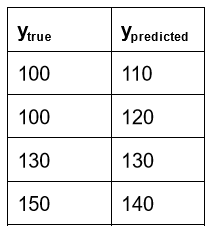
    
Сметнете $MSE$, $RMSE$, $CMMSE$, $R^2$ и $MAE$. 

# 2 част - Класификация

Класификацията ползва малко по-различни методи за оценка. Нека ги разгледаме.

## Точност (Accuracy)

Точността е най-простата метрика е за колко точки предвиждаме правилно:
    
$$
\operatorname{Accuracy} = \frac{1}{n} \sum_{i=1}^n \big[ \hat{y}_i = y_i \big]
$$

Където $\big[ \hat{y}_i = y_i \big]$ е 1 при правилно предвиждане и 0 при грешно.

Показва колко често моделът предсказва верен клас.

Това прави метода `score` при класификационните алгоритми в scikit-learn:

In [19]:
from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

cancer = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(
    cancer.data, cancer.target, stratify=cancer.target, random_state=42)

model = LogisticRegression(C=1.0).fit(X_train, y_train)
model.score(X_test, y_test)

0.958041958041958

## Небалансирани данни

Тази метрика е много неподходяща за данни, в които единия клас има много повече представители от другия. Нека да разгледаме какво се случва.

Ще ползваме друг интересен dataset – digits.

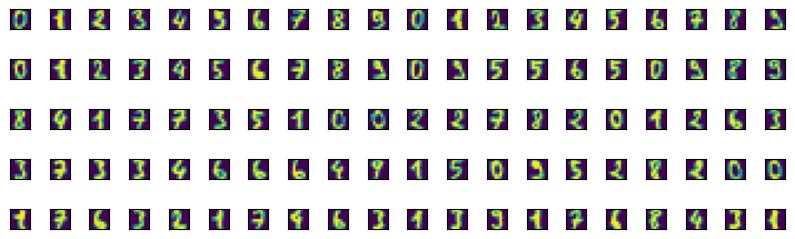

In [52]:
from sklearn.datasets import load_digits

digits = load_digits()

fig, axes = plt.subplots(5, 20, figsize=(10, 5), subplot_kw={'xticks': (), 'yticks': ()})
for ax, img in zip(axes.ravel(), digits.images):
    ax.imshow(img)   
plt.subplots_adjust(wspace=1, hspace=0, top=.5, bottom=0)

Всеки пример е просто 8x8 картинка, представена като масив от пиксели:

In [53]:
digits.data[0]

array([ 0.,  0.,  5., 13.,  9.,  1.,  0.,  0.,  0.,  0., 13., 15., 10.,
       15.,  5.,  0.,  0.,  3., 15.,  2.,  0., 11.,  8.,  0.,  0.,  4.,
       12.,  0.,  0.,  8.,  8.,  0.,  0.,  5.,  8.,  0.,  0.,  9.,  8.,
        0.,  0.,  4., 11.,  0.,  1., 12.,  7.,  0.,  0.,  2., 14.,  5.,
       10., 12.,  0.,  0.,  0.,  0.,  6., 13., 10.,  0.,  0.,  0.])

Ако се загледате внимателно, може да видите нулата по-долу:

In [54]:
digits.data[0].reshape(8, 8)

array([[ 0.,  0.,  5., 13.,  9.,  1.,  0.,  0.],
       [ 0.,  0., 13., 15., 10., 15.,  5.,  0.],
       [ 0.,  3., 15.,  2.,  0., 11.,  8.,  0.],
       [ 0.,  4., 12.,  0.,  0.,  8.,  8.,  0.],
       [ 0.,  5.,  8.,  0.,  0.,  9.,  8.,  0.],
       [ 0.,  4., 11.,  0.,  1., 12.,  7.,  0.],
       [ 0.,  2., 14.,  5., 10., 12.,  0.,  0.],
       [ 0.,  0.,  6., 13., 10.,  0.,  0.,  0.]])

Нека да създадем набор от данни, в който ще се опитваме да отгатваме само 9-ките.

In [55]:
y = digits.target == 9

X_train, X_test, y_train, y_test = train_test_split(digits.data, y, random_state=0, stratify=y)

Какво ли прави логистичната регресия:

In [56]:
logistic = LogisticRegression().fit(X_train, y_train)
logistic.score(X_test, y_test)

0.9644444444444444

96% не е никак зле!

Или?

Да видим какво ще направи един константен модел:

In [57]:
from sklearn.dummy import DummyClassifier

dummy = DummyClassifier(strategy='constant', constant=0).fit(X_train, y_train)
dummy.score(X_test, y_test)

0.9

Явно може и по-лесно да постигнем 90% точност.

Представете си, че имаме рядко заболяване – имат го само 1% от хората. Може да постигнем 99% точност просто като винаги отговаряме "пациента е здрав". Това не е много добър модел.

За да се справим с това ползваме малко по-различни метрики.

## Матрица на грешките (Confusion matrix)

Първата интересна графика е матрицата на грешките (confusion matrix, error matrix). За да я начертаем ни трябват 4 числа:

* True Positives (TP) – $\hat{y} = 1$, за които сме предвидили правилно
* False Positives (FP) – $\hat{y} = 1$, за които сме предвидили грешно
* True Negatives (TN) – $\hat{y} = 0$, за които сме предвидили правилно
* False Negatives (FN) – $\hat{y} = 0$, за които сме предвидили грешно

Обърнете внимание, че при бинарната класификация често наричаме единия клас "позитивен" ($y = 1$). Това може да е "спам" в мейлите, "злокачествен" при туморите и "девятка" при числата.

Confusion matrix е просто следната таблица:

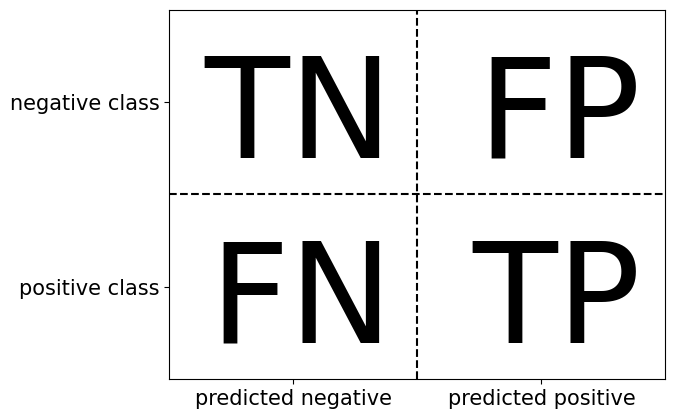

In [58]:
mglearn.plots.plot_binary_confusion_matrix()

Scikit-learn има функция, която дава метриките на матрицата на грешките:

In [59]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, dummy.predict(X_test))

array([[405,   0],
       [ 45,   0]])

Така по-лесно може да се ориентираме в резултата и да видим, че има проблем.

Логистичната регресия се справя по-добре:

In [60]:
confusion_matrix(y_test, logistic.predict(X_test))

array([[395,  10],
       [  6,  39]])

Хората се радват на шарено. Нека си направим функция за чертаeне на матрица на грешките:

In [61]:
import itertools

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues,
                          figsize=(6, 5)):
    matrix = confusion_matrix(y_true, y_pred)

    if normalize:
        matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=figsize)
    plt.imshow(matrix, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = matrix.max() / 2.
    for i, j in itertools.product(range(matrix.shape[0]), range(matrix.shape[1])):
        plt.text(j, i, format(matrix[i, j], fmt),
                 horizontalalignment="center",
                 size=int((figsize[0] / 10) * 38),
                 color="white" if matrix[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

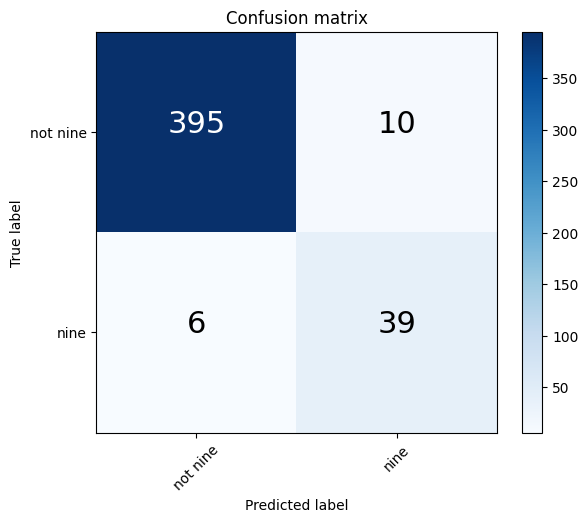

In [62]:
plot_confusion_matrix(y_test, logistic.predict(X_test), ['not nine', 'nine'])

Така числата са малко трудни за разбиране. Затова имаме `normalize=True`:

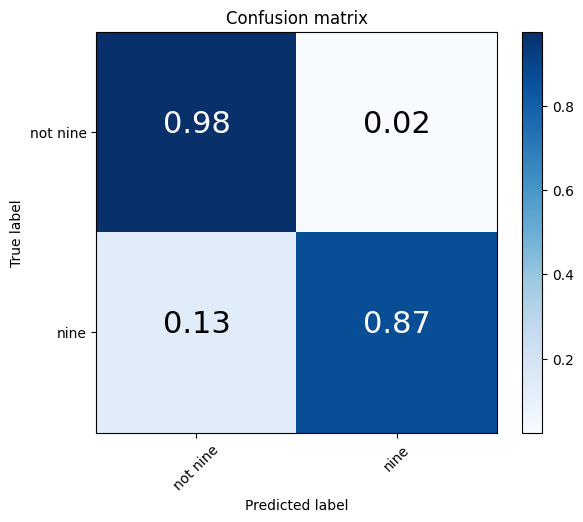

In [63]:
plot_confusion_matrix(y_test, logistic.predict(X_test), ['not nine', 'nine'], normalize=True)

Виждаме, че познаваме "not-nine" в 98% от случаите и "nine" в 89%.

Как ли се справя глупавия ни модел?

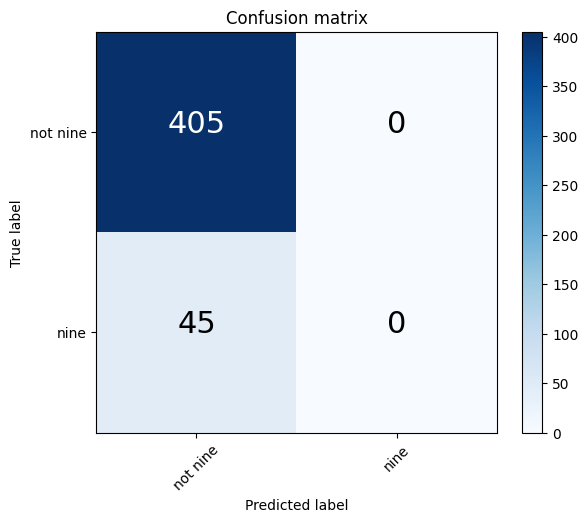

In [64]:
plot_confusion_matrix(y_test, dummy.predict(X_test), ['not nine', 'nine'])

Тук ясно се вижда проблема.

Като цяло, оптималната матрица е с положителни числа по основния диагонал и нули извън него.

## Прецизност (Precision)

Precision е метрика, която се опитва да намали False Positives:

$$ \operatorname{Precision} = \frac{\operatorname{TP}}{\operatorname{TP} + \operatorname{FP}} $$

Тя е важна когато искаме да сме сигурни в позитивното си предвиждане.

### Примери за важна прецизност

Представете си, че правим система за автоматично бомбардиране на терористи. Алгоритъма преценява дали даден човек е терорист, и ако е такъв, го бомбардираме. Искаме да минимизираме (или отстраним) цивилните жертви – за нас е много важно да сме сигурни в оценката на алгоритъма, когато предвиди "терорист". Съответно, търсим алгоритъм с добър precision.

Аналогичен случай е спама – ако алгоритъма е решил, че определ имейл е спам, искаме да сме много сигурни в това, преди да го изтрием. Предпотичаме имейлите на кантар да не са спам, пред това да изтрием нещо важно.

## Възвръщаемост (Recall)

Recall е аналогична метрика:

$$ \operatorname{Recall} = \frac{\operatorname{TP}}{\operatorname{TP} + \operatorname{FN}} $$

Тя е важна, когато искаме да сме много сигурни, че ще хванем всички позитивни данни.

### Пример за важна възвръщаемост

Добър пример за това са туморите. Цената на false positive е различна от тази на false negative. При false positive ще кажем на здрав пациент, че може да е болен. Това ще струва допълнителни изследвания и малко емоционални мъки. При false negative може да пропуснем да направим лечение и да застрашим живота на пациента. В този случай предпочитаме алгоритъма ни да има висок recall.

## Precision и recall илюстрирани

Лесен начин да помним двете метрики е `TP` разделено на сбора на реда или колоната:

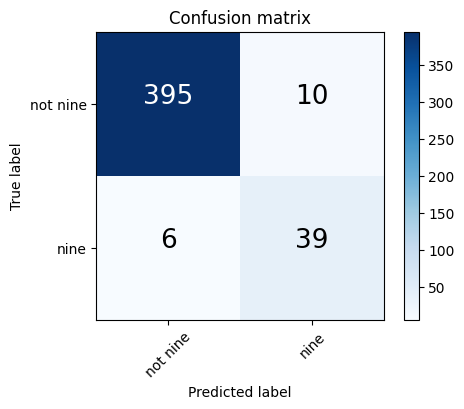

In [65]:
plot_confusion_matrix(y_test, logistic.predict(X_test), ['not nine', 'nine'], figsize=(5, 4))

Precision е 395 разделено на сбора на първата колона, докато recall е 395 разделено на сбора на първия ред. 

## $F_1$ score

Ако метрика която взема и двете числа предвид, може да ползваме $F_1$ оценка. Това е хармоничната средна стойност на двете:

$$ F_1 = 2 \cdot \frac{\operatorname{precision} \cdot \operatorname{recall}}{\operatorname{precision} + \operatorname{recall}} $$

In [66]:
from sklearn.metrics import f1_score

f1_score(y_test, logistic.predict(X_test))

0.8297872340425532

Функцията `classification_report` в scikit-learn може да ни даде всички основни метрики от матрицата на грешките:

In [67]:
from sklearn.metrics import classification_report
print(classification_report(y_test, logistic.predict(X_test), target_names=['not nine', 'nine']))

              precision    recall  f1-score   support

    not nine       0.99      0.98      0.98       405
        nine       0.80      0.87      0.83        45

    accuracy                           0.96       450
   macro avg       0.89      0.92      0.90       450
weighted avg       0.97      0.96      0.97       450



Нека да пробваме с още един dummy класификатор (с магически random state):

In [68]:
dummy = DummyClassifier(random_state=7260, strategy='stratified').fit(X_train, y_train)

Ако гледаме само `score`, няма да видим твърде драматична разлика:

In [69]:
print("Dummy score:    {}".format(dummy.score(X_test, y_test)))
print("Logistic score: {}".format(logistic.score(X_test, y_test)))

Dummy score:    0.8688888888888889
Logistic score: 0.9644444444444444


Разликите си личат в пълния репорт:

In [70]:
print("Dummy Classifier:\n\n", classification_report(y_test, dummy.predict(X_test), target_names=['not nine', 'nine']))
print("Logistic Regression:\n\n", classification_report(y_test, logistic.predict(X_test), target_names=['not nine', 'nine']))

Dummy Classifier:

               precision    recall  f1-score   support

    not nine       0.91      0.94      0.93       405
        nine       0.28      0.20      0.23        45

    accuracy                           0.87       450
   macro avg       0.60      0.57      0.58       450
weighted avg       0.85      0.87      0.86       450

Logistic Regression:

               precision    recall  f1-score   support

    not nine       0.99      0.98      0.98       405
        nine       0.80      0.87      0.83        45

    accuracy                           0.96       450
   macro avg       0.89      0.92      0.90       450
weighted avg       0.97      0.96      0.97       450



### Задача 

За последната матрица на грешките сметнете точност, прецизност, възвръщаемост и $F_1$ оценка.

## Увереност на модела

Повечето класификационни модели имат още една хватка – могат да дават увереност колко са убедени в модела си. Нека разгледаме един синтетичен пирмер.

In [71]:
from sklearn.datasets import make_circles

X, y = make_circles(noise=0.25, factor=0.5, random_state=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

Да видим как изглеждат тези данни:

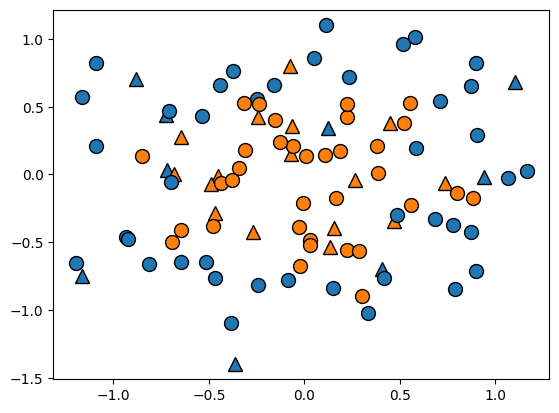

In [72]:
mglearn.discrete_scatter(X_test[:, 0], X_test[:, 1], y_test, markers='^')
mglearn.discrete_scatter(X_train[:, 0], X_train[:, 1], y_train, markers='o');

Да го пробваме с `GradientBoostingClasifier` (от семейство decision trees):

In [73]:
from sklearn.ensemble import GradientBoostingClassifier

gbrt = GradientBoostingClassifier(random_state=0)
gbrt.fit(X_train, y_train);

Нека да начертаем границата:

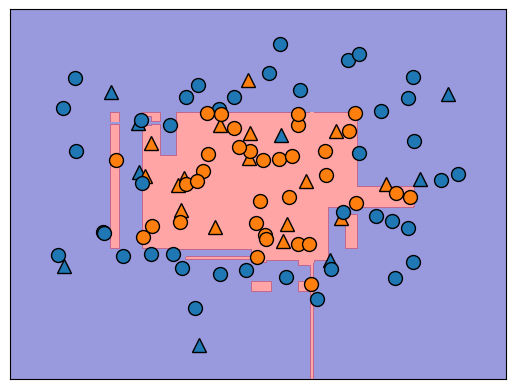

In [74]:
mglearn.tools.plot_2d_separator(gbrt, X, alpha=.4, fill=True, cm=mglearn.cm2)
mglearn.discrete_scatter(X_test[:, 0], X_test[:, 1], y_test, markers='^')
mglearn.discrete_scatter(X_train[:, 0], X_train[:, 1], y_train, markers='o');

## Вероятности

Повечето класификационни модели имат функция `predict_proba`, която показва вероятността на всеки клас (според класификатора):

In [75]:
gbrt.predict_proba(X_test[:6])

array([[0.01573626, 0.98426374],
       [0.84575653, 0.15424347],
       [0.98112869, 0.01887131],
       [0.97407033, 0.02592967],
       [0.01352142, 0.98647858],
       [0.02504637, 0.97495363]])

Първото число е вероятността за първия клас, второто – за втория. Може да видим, че модела е по-убеден за едни точки, отколкото за други.

Също така, сборът на двете е 1 (до floating point точност).

## Функция на решение (Decision function)

Моделите имат и `decision_function`, който е числото зад тези неща.

Стойността на `decision_function` зависи от конкретния модел и обикновено е нещо абстрактно. Вероятността е функция на нейния резултат.

In [76]:
gbrt.decision_function(X_test[:6])

array([ 4.13592603, -1.70169917, -3.95106099, -3.62609552,  4.28986642,
        3.66166081])

Нека си направим таблица:

In [77]:
frame = pd.DataFrame(
    np.hstack((
        gbrt.predict_proba(X_test).round(4),
        gbrt.decision_function(X_test).reshape(-1, 1).round(4),
        gbrt.predict(X_test).reshape(-1, 1),
    )),
    columns=['blue %', 'red %', 'decision function', 'answer']
)
frame['color'] = np.array(['blue', 'red'])[frame['answer'].astype(int)]
frame

,blue %,red %,decision function,answer,color
0,0.0157,0.9843,4.1359,1.0,red
1,0.8458,0.1542,-1.7017,0.0,blue
2,0.9811,0.0189,-3.9511,0.0,blue
3,0.9741,0.0259,-3.6261,0.0,blue
4,0.0135,0.9865,4.2899,1.0,red
5,0.0250,0.9750,3.6617,1.0,red
6,0.9995,0.0005,-7.6910,0.0,blue
7,0.0161,0.9839,4.1100,1.0,red
8,0.2483,0.7517,1.1075,1.0,red
9,0.0321,0.9679,3.4078,1.0,red


Тук виждаме няколко неща:

* Положителен резултат от decision function се оценява като 1.0, а отрицателен като 0.0.
* Колкото по-голяма е стойността на функцията, толкова по-уверен е алгоритъма – имаме 98% при 4.13 и 65% при 0.65.
* Най-вероятно decision функцията минава през сигмоид.

Нека наречтаем това на графика:

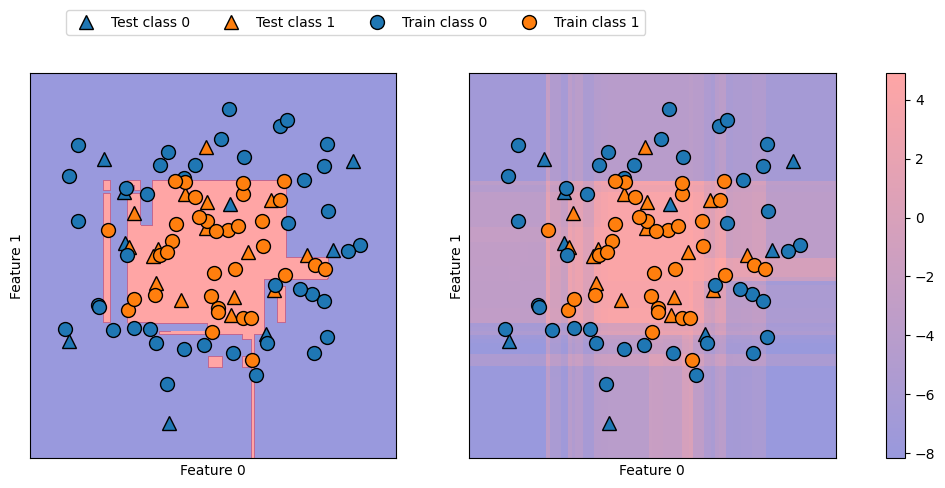

In [78]:
fig, axes = plt.subplots(1, 2, figsize=(13, 5))
mglearn.tools.plot_2d_separator(gbrt, X, ax=axes[0], alpha=.4, fill=True, cm=mglearn.cm2)
scores_image = mglearn.tools.plot_2d_scores(gbrt, X, ax=axes[1], alpha=.4, cm=mglearn.ReBl)

for ax in axes:
    mglearn.discrete_scatter(X_test[:, 0], X_test[:, 1], y_test, markers='^', ax=ax)
    mglearn.discrete_scatter(X_train[:, 0], X_train[:, 1], y_train, markers='o', ax=ax)
    ax.set_xlabel("Feature 0")
    ax.set_ylabel("Feature 1")

cbar = plt.colorbar(scores_image, ax=axes.tolist())
axes[0].legend(["Test class 0", "Test class 1", "Train class 0", "Train class 1"], ncol=4, loc=(.1, 1.1));

Фонът във втората диаграма показва стойността на decision функцията. Може да съобразим, че алгоритъма сравнява с някакъв threshold и така определя класа. В този конретен случай изглежда, че сравнява с 0.

Бихме могли да го тестваме:

In [79]:
np.all(gbrt.predict(X_test) == (gbrt.decision_function(X_test) > 0))

np.True_

Ако ползваме `decision_function` вместо `predict` може да наклоним класификатора в определена посока:

In [80]:
print("df > 0:  {}".format(gbrt.predict(X_test).sum()))
print("df > 4:  {}".format((gbrt.decision_function(X_test) > 4).sum()))
print("df > -4: {}".format((gbrt.decision_function(X_test) > -4).sum()))

df > 0:  14
df > 4:  7
df > -4: 22


Може да начертаем границата на решението (decision boundary) при различните варианти:

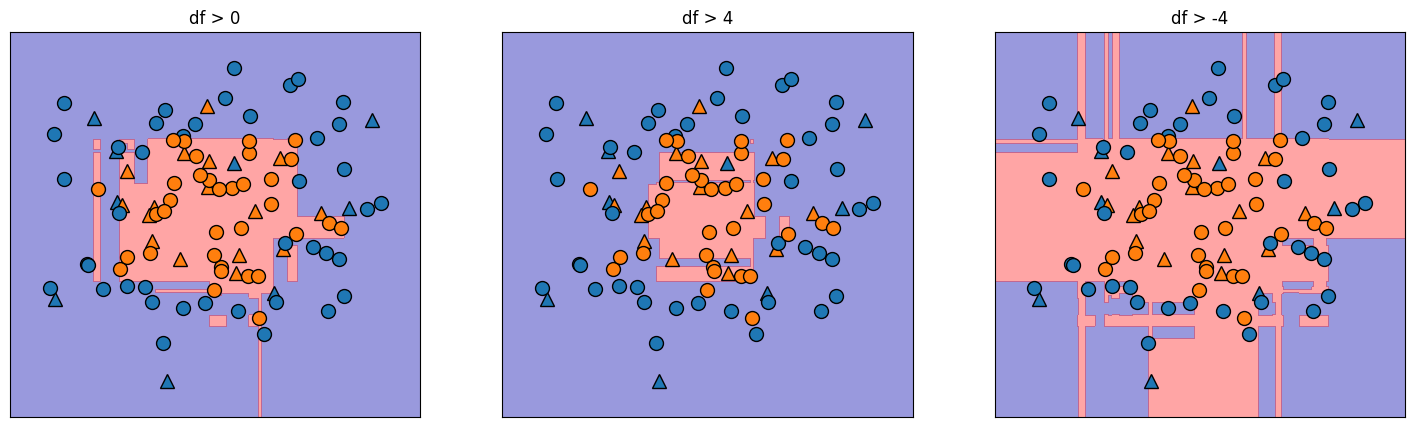

In [81]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for (ax, threshold) in zip(axes, [0, 4, -4]):
    mglearn.tools.plot_2d_separator(gbrt, X, ax=ax, alpha=.4, threshold=threshold, fill=True, cm=mglearn.cm2)
    mglearn.discrete_scatter(X_test[:, 0], X_test[:, 1], y_test, markers='^', ax=ax)
    mglearn.discrete_scatter(X_train[:, 0], X_train[:, 1], y_train, markers='o', ax=ax)
    ax.set_title("df > {}".format(threshold))

Виждаме, че при промяна на стойноста, с която сравняваме, започваме да предпочитаме единия клас пред другия.

Гледайки горната таблица, при праг > 4 имаме увереност над 98%. Така бихме могли да правим trade-off между decision и recall.

In [82]:
print("Report at df > 0:\n")
print(classification_report(y_test, gbrt.predict(X_test)))
print("Report at df > -4:\n")
print(classification_report(y_test, gbrt.decision_function(X_test) > -4))

Report at df > 0:

              precision    recall  f1-score   support

           0       0.73      0.89      0.80         9
           1       0.93      0.81      0.87        16

    accuracy                           0.84        25
   macro avg       0.83      0.85      0.83        25
weighted avg       0.86      0.84      0.84        25

Report at df > -4:

              precision    recall  f1-score   support

           0       0.67      0.22      0.33         9
           1       0.68      0.94      0.79        16

    accuracy                           0.68        25
   macro avg       0.67      0.58      0.56        25
weighted avg       0.68      0.68      0.63        25



Може да видим, че за позитивня клас (1) сме увеличили recall от 0.81 до 0.94 за сметка на всичко останало. Понякога това може да желано.

Всичко това ни е нужно да обясним финалните метрики за класификация.

# Precision-recall curve

За видим precision-recall curve, нека да започнем с други данни:

In [102]:
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=(4000, 500), cluster_std=[7.0, 2], random_state=22)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

Нека да видим как изглежда:

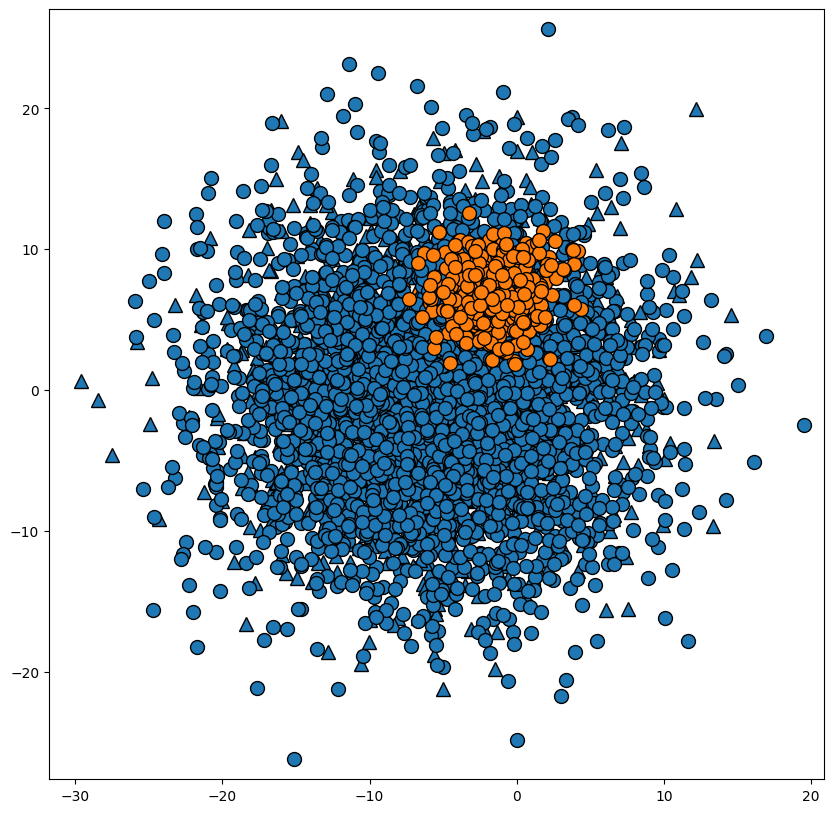

In [103]:
plt.figure(figsize=(10, 10))
mglearn.discrete_scatter(X_test[:, 0], X_test[:, 1], y_test, markers='^')
mglearn.discrete_scatter(X_train[:, 0], X_train[:, 1], y_train, markers='o');

Ще тренираме друг класификатор (`SVC`), който няма да обясняваме подробно. Просто може да знаем, че е класификатор:

In [104]:
from sklearn.svm import SVC

svc = SVC(gamma=.05).fit(X_train, y_train)

Може да видим класификационния репорт с прага по подразбиране:

In [105]:
print(classification_report(y_test, svc.predict(X_test)))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96      1004
           1       0.64      0.67      0.66       121

    accuracy                           0.92      1125
   macro avg       0.80      0.81      0.81      1125
weighted avg       0.93      0.92      0.93      1125



Интересно е да видим как ще променят recall и precision, ако променяме прага на вземане на решение (threshold). Може да начертаем графика с `precision_recall_curve`:

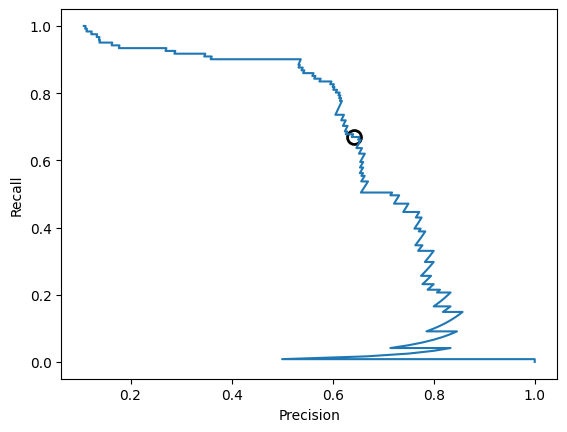

In [106]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_test, svc.decision_function(X_test))

close_zero = np.argmin(np.abs(thresholds))
plt.plot(precision[close_zero], recall[close_zero], 'o', markersize=10, label='threshold zero', fillstyle='none', c='k', mew=2)
plt.plot(precision, recall, label='precision recall curve')
plt.xlabel('Precision')
plt.ylabel('Recall');

In [92]:
close_zero

np.int64(999)

На тази графика виждаме:

* Точката избрана от модела (при $y$ = 1).
* Връзката между presicion и recall при промяна на прага.
* В този модел виждаме, че може да получим precision = 0.5 при висок recall. Ако искаме повече precision трябва да жертваме recall.
* Колкото по-близо е кривата до горния десен ъгъл, толкова по-добре – т.е. може да имаме едновременно висок precision и recall.

Различните модели ще имат различна крива. Да пробваме с друг:

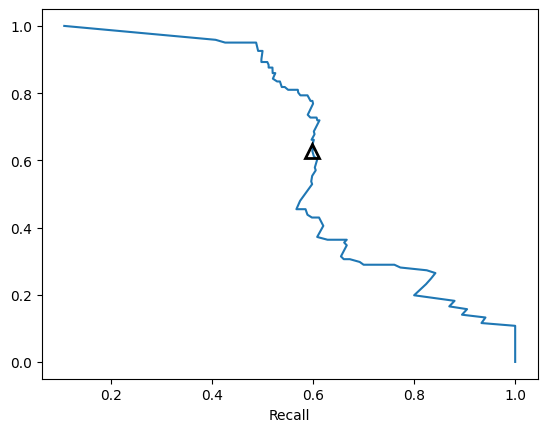

In [ ]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(n_estimators=100, random_state=0, max_features=2)
forest.fit(X_train, y_train)

precision_rf, recall_rf, thresholds_rf = precision_recall_curve(y_test, forest.predict_proba(X_test)[:, 1])

close_default_rf = np.argmin(np.abs(thresholds_rf - 0.5))

plt.plot(precision_rf, recall_rf, label='rf')
plt.plot(precision_rf[close_default_rf], recall_rf[close_default_rf], '^', c='k', markersize=10, label='threshold 0.5 rf', fillstyle='none', mew=2)
plt.xlabel('Precision')
plt.xlabel('Recall');

Може да видим и двете заедно на една графика:

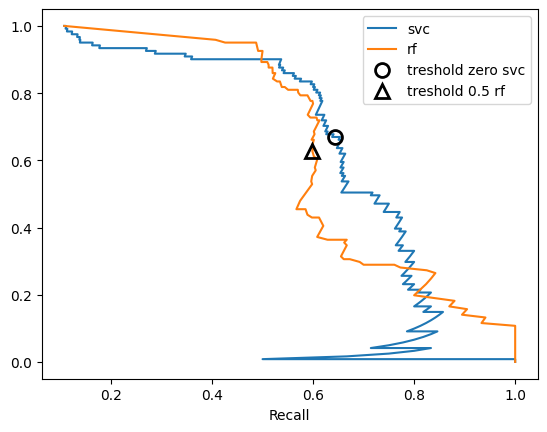

In [ ]:
plt.plot(precision, recall, label='svc')
plt.plot(precision_rf, recall_rf, label='rf')
plt.plot(precision[close_zero], recall[close_zero], 'o', markersize=10, label='threshold zero svc', fillstyle='none', c='k', mew=2)
plt.plot(precision_rf[close_default_rf], recall_rf[close_default_rf], '^', c='k', markersize=10, label='threshold 0.5 rf', fillstyle='none', mew=2)
plt.xlabel('Precision')
plt.xlabel('Recall')
plt.legend(loc='best');

От графиката се вижда, че support vector машината се оправя по-добре в средната точка, но RF се справя по-добре с крайностите. Това не се вижда в $f_1$ оценката:

In [96]:
print("f₁ for SVC:           {}".format(f1_score(y_test, svc.predict(X_test))))
print("f₁ for Random Forest: {}".format(f1_score(y_test, forest.predict(X_test))))

f₁ for SVC:           0.6558704453441295
f₁ for Random Forest: 0.6097560975609757


## AUC 

Друга метрика е площта под кривата (Area under the curve, AUC). Scikit-learn има функция и за това:

In [96]:
from sklearn.metrics import average_precision_score

print("AUC for SVC:           {}".format(average_precision_score(y_test, svc.decision_function(X_test))))
print("AUC for Random Forest: {}".format(average_precision_score(y_test, forest.predict_proba(X_test)[:, 1])))

AUC for SVC:           0.6663140319391998
AUC for Random Forest: 0.659559370099291


## Крос-ентропия (Cross Entropy, Logarithmic loss, LogLoss)

Често се използва като целева функция (cost function) при оптимизиране на класификация. При двоична класификация:

$$
\operatorname{LogLoss} = - \frac {1}{n} \sum_{i=1}^n \Big( y_i \ln(p_i) + (1 - y_i) \ln(1 - p_i) \Big)
$$

Където:

* $y_i \in \{0, 1\}$ – класът на $i$-тия елемент
* $p_i$ – вероятността предвиждането на $i$-тия елемент да е 1

По-подробна информация - в [тази блог-статия](https://www.analyticsvidhya.com/blog/2020/11/binary-cross-entropy-aka-log-loss-the-cost-function-used-in-logistic-regression/).

Пример:

Предсказваме клас 1 с вероятност 0.9 и истинския клас е 1:


$$
\operatorname{LogLoss} = - \big ( 1 * log(0.9) + (1 - 1) * log(1 - 0.9) \big ) =
$$

$$
= -  \big (-0.105 + 0  \big ) = 0.105
$$



Предсказваме клас 1 с вероятност 0.9 и истинския клас е 0:


$$
\operatorname{LogLoss} = - \big ( 0 * log(0.9) + (1 - 0) * log(1 - 0.9) \big ) =
$$

$$
= -  \big ( 0  - 2.3  \big ) = 2.3
$$


При много класове:

$$
\operatorname{LogLoss} = - \frac {1}{n} \sum_{i=1}^n \sum_{j=1}^l \sigma_{ij}\ln(p_{ij} ) 
$$

Където:

* $l \in \mathbb{N}$ – броя класове
* $\sigma_{ij} \in \{0, 1\}$ – 1 ако $i$-тия елемент е от клас $j$, иначе 0
* $p_{ij} \in [0, 1]$ – вероятността (според модела) $i$-тия елемент да е от клас $j$

In [97]:
from sklearn.metrics import log_loss, accuracy_score

def plot_log_loss():
    plt.figure(figsize=(16, 4))
    plt.subplot(1,2,1)
    plt.title('Клас 1')
    x = np.linspace(0, 1)
    loss_log = [log_loss([1], [x], labels=[0, 1]) for x in x]

    plt.plot(x, loss_log); plt.grid();
    plt.plot(x, 1 -x);
    plt.ylim(-0.1, 8)
    plt.ylabel('Натрупана грешка за 1 семпъл')
    plt.xlabel('Разлика във вероятността от истинския клас')

    plt.subplot(1,2,2)
    plt.title('Клас 0')
    
    x = np.linspace(0, 1)
    loss_log = [log_loss([0], [x], labels=[0, 1]) for x in x]

    plt.ylim(-0.1, 8)
    plt.plot(x, loss_log); plt.grid();
    plt.plot(x, x);
    plt.xlabel('Разлика във вероятността от истинския клас')
    plt.legend(['LogLoss', 'Абсолютна разлика'])

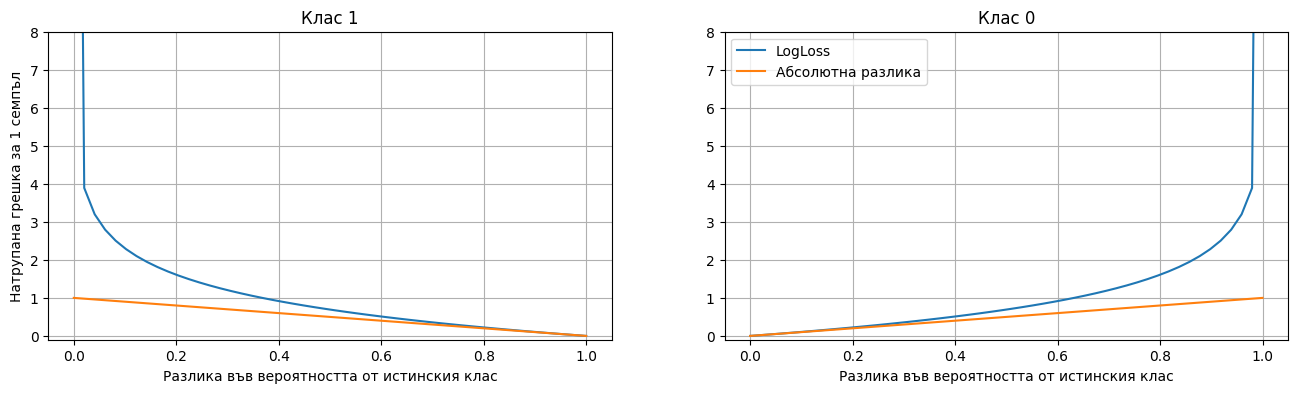

In [98]:
plot_log_loss()

Вижда се, че тази функция наказва модел, който е много уверен в грешните неща. Оптимизирането й води до модел, е по-консервативен във вероятностите си.

Това е функцията, която се оптимизира при логистична регресия.

Най-добрия константен модел:

Настройваме вероятностите за всеки клас да са равни на съответните честоти на класа.
    
При данни:
- 10 кучета
- 90 котки

Вероятностите са [0.1, 0.9] за двата класа.

## Допълнително: Sensitivity and specificity

Recall и precision са само част от голям набор от метрики, базирани на TP, FP, TN и FN. В машинното самообучение те се ползват най-често, но има и много други. Ако ви е любопитно, wikipedia има много добра статия по въпроса:

https://en.wikipedia.org/wiki/Sensitivity_and_specificity

# 3 част - валидация на модели 

Има различни схеми за разделяне на множеството от данните, така че да гарантираме, че направената оценка е адекватна и достатъчно обобщаваща. 

## Train-test split

Да се тренира и тества модел върху едни и същи данни се счита за грешка. Достатъчно сложен модел може да научи перфектно резултата за всеки вход за данните с които се тренира. Това не означава, че ще генерализира добре.

В `sklearn` можем да използваме функцията `train_test_split` за бързо разделяне на данните на две части:

1. За трениране на модел: `X_train` и `y_train`
2. За оценяване на модел: `X_test` и `y_test`

`train_test_split` прави и случайно разбъркване на данните.

In [99]:
from sklearn.datasets import load_iris

iris = load_iris()
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.4, random_state=0)

print("Train shape:", X_train.shape, y_train.shape)
print("Test shape: ", X_test.shape, y_test.shape)

Train shape: (90, 4) (90,)
Test shape:  (60, 4) (60,)


## Валидационно множество

Имаме следната ситуация:

* Когато настройваме различни хиперпараметри (`alpha`, `max_depth`, `n_features`, и т.н.) се появява шанс за пренагаждане.
* При значителен брой итерации върху тестовото множество, информация за него може да "изтече" към модела.
* В този момент модела става оптимален за конкретното тестово множество, но не генерализира толкова добре на нови данни.

За да се реши този проблем се прави разделяне на данните с още едно множество, което се нарича "валидационно множество" (*validation set, developement set*).

## Train-dev-test split

На практика данните се разделят на 3 части:

1. Тренировъчно множество (train set)
   * Служи за многократно трениране на модела с различни настройки (хиперпараметри).
2. Валидационно множество (val/dev set) 
   * Служи като тестово множество за всяко претрениране на модела с различни настройки.
   * След изседване на различни комбинации на параметри се избира моделът, показващ най-добър резултат върху валидационното множество.
3. Тестово множество (test set)
   * Използва се само веднъж, след като сме приключили с експериментите и сме избрали най-добрия модел.
   * Целта е да видим какви са показателите на модела върху нови данни.

## Крос-валидация (cross validation) 

Какво става, ако данните не са достатъчно?

Може да ползваме cross (кръстосана) валидация.

* Крос валидацията разделя тренировачното множество на $k$ части.
* Прави $k$ на брой тренирания с $k - 1$ части и винаги оставя една част за валидация.
* Оцененката от крос валидацията е средната оценка от всички $k$ тренирания и оценявания.

Или на картинка:

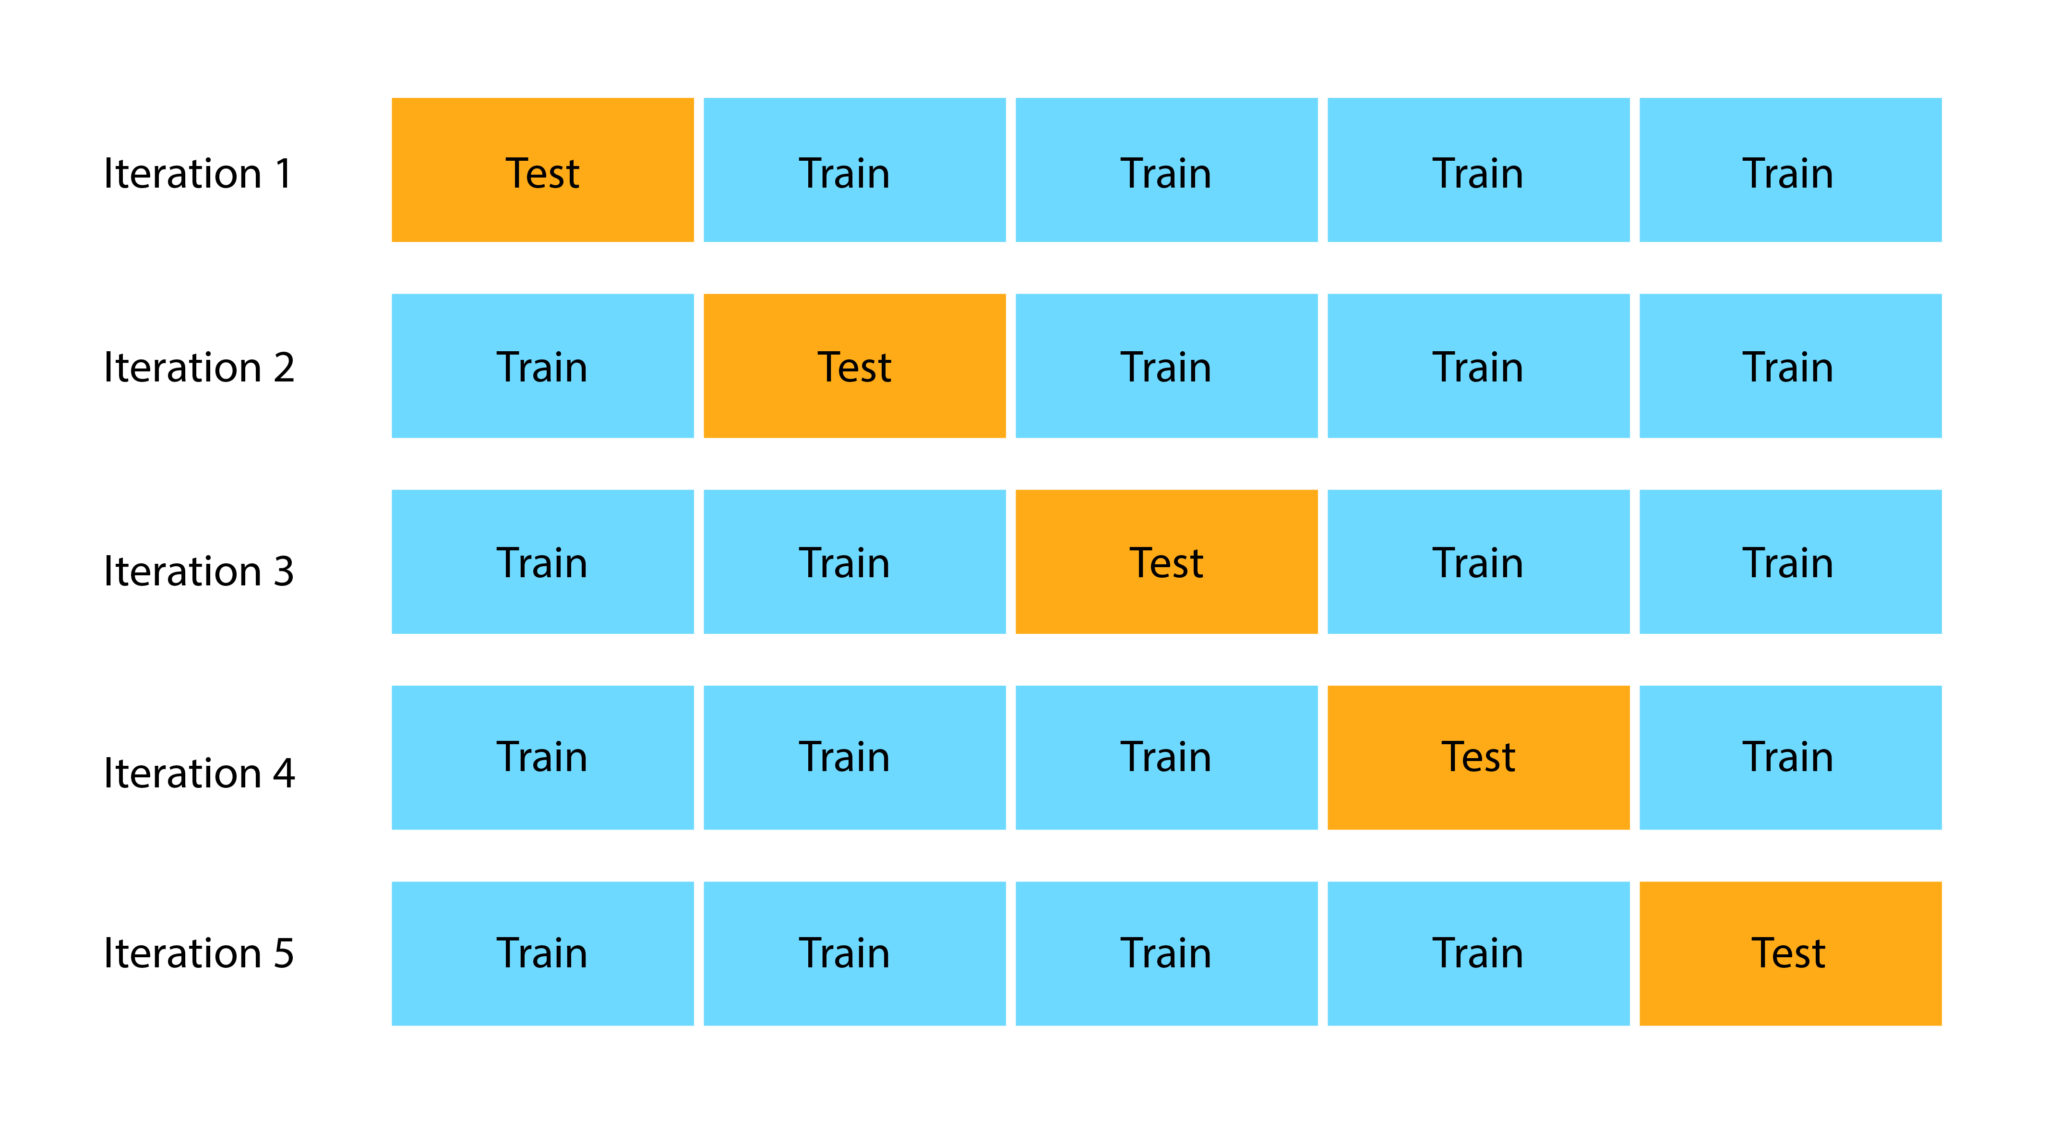!

Може да ползваме `cross_val_score` за да направи тази операция:

In [104]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

logistic = LogisticRegression()

scores = cross_val_score(logistic, iris.data, iris.target, cv=10, scoring='accuracy')
print(scores)
print("Mean: {}".format(scores.mean()))
print("Std:  {}".format(scores.std()))

[1.         0.93333333 1.         1.         0.93333333 0.93333333
 0.93333333 1.         1.         1.        ]
Mean: 0.9733333333333334
Std:  0.03265986323710904


Обърнете внимание, че:

* Крос валидацията показва дали има вариация в модела.
* Облекчава проблема с неприятен разрез на данните от `train_test_split`.
* По подразбиране `cross_val_score` запазва пропорциите на класовете в двете множествата. 
* Може да се наложи предварително да размесим данните - не става автоматично.
* За всяко оценяване трябва да бъдат направени k тренирания и оценявания на различни части от тренировачното множество.

## Параметри

Параметърът `cv` може да приема следните стойности:

* По подразбиране `None` използва три-кратно крос валидиране.
* `int` - k-кратно крос валидиране, където k е подаденото число.
* Обект, използван за генериране на валидационни множества, например `StratifiedKFold`.
* Python iterable, връщащ двойка `(train, validation)` множества

## Допълнителна информация

Има друга функция, `cross_validate` която дава повече информация:

In [100]:
from sklearn.model_selection import cross_validate

scoring = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']

logistic = LogisticRegression()
scores = cross_validate(logistic, iris.data, iris.target, scoring=scoring, cv=5, return_train_score=False)
pd.DataFrame(scores)

,fit_time,score_time,test_accuracy,test_precision_macro,test_recall_macro,test_f1_macro
0,0.063018,0.005317,0.966667,0.969697,0.966667,0.966583
1,0.031055,0.005205,1.000000,1.000000,1.000000,1.000000
2,0.031158,0.005125,0.933333,0.944444,0.933333,0.932660
3,0.025966,0.004697,0.966667,0.969697,0.966667,0.966583
4,0.023155,0.006347,1.000000,1.000000,1.000000,1.000000


Ако търсим средни стойности, може да се пробваме с `mean`:

In [119]:
pd.DataFrame(scores).mean()

fit_time                0.019878
score_time              0.003531
test_accuracy           0.973333
test_precision_macro    0.976768
test_recall_macro       0.973333
test_f1_macro           0.973165
dtype: float64

## Leave-one-out валидация

Частния случай $k = n$ се нарича leave one out. В него правим по едно трениране за всеки елемент:

In [110]:
from sklearn.model_selection import LeaveOneOut

X = np.array([1, 2, 3, 4])
y = np.array([0.1, 0.2, 0.3, 0.4])

leave_one_out = LeaveOneOut()
for train_idx, test_idx in leave_one_out.split(X):
    print("* train: {} {}   test: {} {}".format(X[train_idx], y[train_idx], X[test_idx], y[test_idx]))

* train: [2 3 4] [0.2 0.3 0.4]   test: [1] [0.1]
* train: [1 3 4] [0.1 0.3 0.4]   test: [2] [0.2]
* train: [1 2 4] [0.1 0.2 0.4]   test: [3] [0.3]
* train: [1 2 3] [0.1 0.2 0.3]   test: [4] [0.4]


Може да ползваме `LeaveOneOut` за оценка по следния начин:

In [111]:
logistic = LogisticRegression()
scores = cross_val_score(logistic, iris.data, iris.target, cv=LeaveOneOut())

print(scores.mean())
print(scores)

0.9666666666666667
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1.
 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1.]


Има и `cross_val_predict`, който прави предвиждания:

In [112]:
from sklearn.model_selection import cross_val_predict

logistic = LogisticRegression()
y_pred = cross_val_predict(logistic, iris.data, iris.target, cv=LeaveOneOut())

print(y_pred)
print(iris.target)
print((y_pred == iris.target).mean())

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1
 1 1 1 2 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 1 2 2 2 2
 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]
0.9666666666666667


## Стратифицирана крос валидация (Stratified k-fold)

Да отбележим още веднъж, че при, класификация, частите от данните (folds), генерирани от крос валидация трябва да запазват пропорциите на класовете. Важно е всеки клас да бъде представен равномерно във всеки всяка:

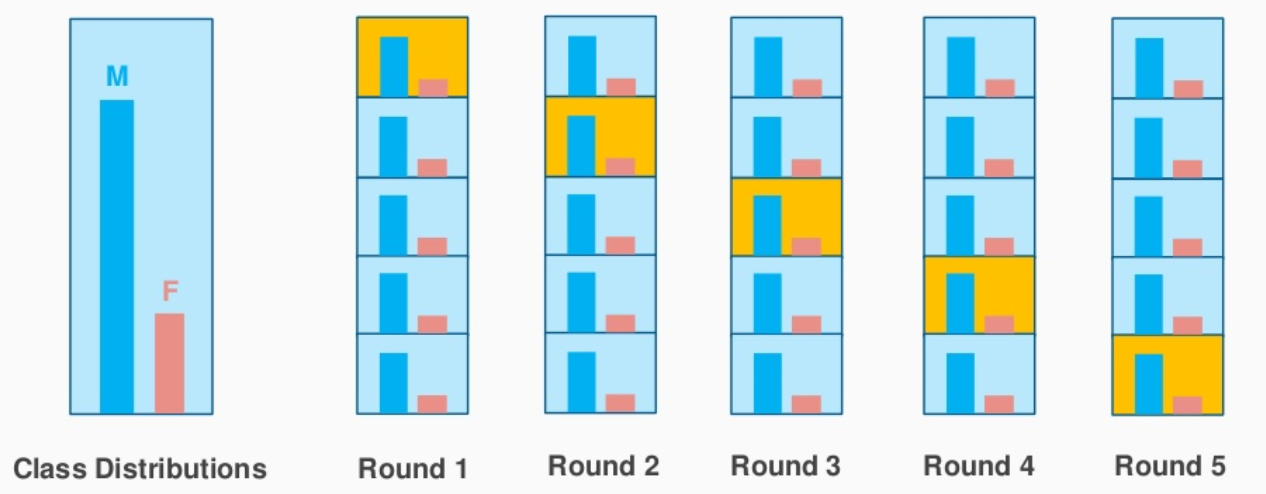

`cross_val_score` сам се сеща да го направи при класификация, но понякога може да се наложи да ползвате `StratifiedKFold`.

## Крос валидация на времеви редове (time series)
* Данните с времева серия се характеризират с корелацията между наблюденията, които са близки във времето (автокорелация). 
* Техники за кръстосано валидиране, като `KFold` и `ShuffleSplit`, предполагат, че пробите са независими и идентично разпределени.
* Това би довело до неразумна връзка между тренировъчните и валидационни множества (водещи до лоши оценки на грешката за генерализация).
* Поради това е много важно да оценим модела с данни от динамични редове за "бъдещите" наблюдения. 
* За да се постигне това, се използва класа `TimeSeriesSplit`.

In [115]:
from sklearn.model_selection import TimeSeriesSplit

X = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
y = np.array([0, 1, 0, 1, 0, 1, 0, 1, 0, 1])

series_split = TimeSeriesSplit(n_splits=3, max_train_size=5)

for train_idx, test_idx in series_split.split(X):
    print('* train: {} test: {}'.format(X[train_idx], X[test_idx]))

* train: [0 1 2 3] test: [4 5]
* train: [1 2 3 4 5] test: [6 7]
* train: [3 4 5 6 7] test: [8 9]


## Въпроси?

## Задача 
Оценете `iris` чрез крос валидация и стратифицирана крос валидация при различна стойност на параметъра k. 
Коя според вас е добра стойност на параметъра? 